http://aqibsaeed.github.io/2016-07-17-anomaly-detection/

https://www.datascience.com/blog/python-anomaly-detection

https://www.kaggle.com/imrandude/h2o-autoencoders-and-anomaly-detection-python/notebook

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,Normalizer
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
from pylab import rcParams
rcParams['figure.figsize']=15,10

In [7]:
student=pd.read_csv('studentDropIndia_20161215.csv', sep=',')
student.isnull().any()

continue_drop         False
student_id            False
gender                False
caste                 False
mathematics_marks     False
english_marks         False
science_marks         False
science_teacher       False
languages_teacher     False
guardian              False
internet              False
school_id             False
total_students        False
total_toilets          True
establishment_year     True
dtype: bool

In [8]:
### Fill NA with 0
student=student.fillna(0)

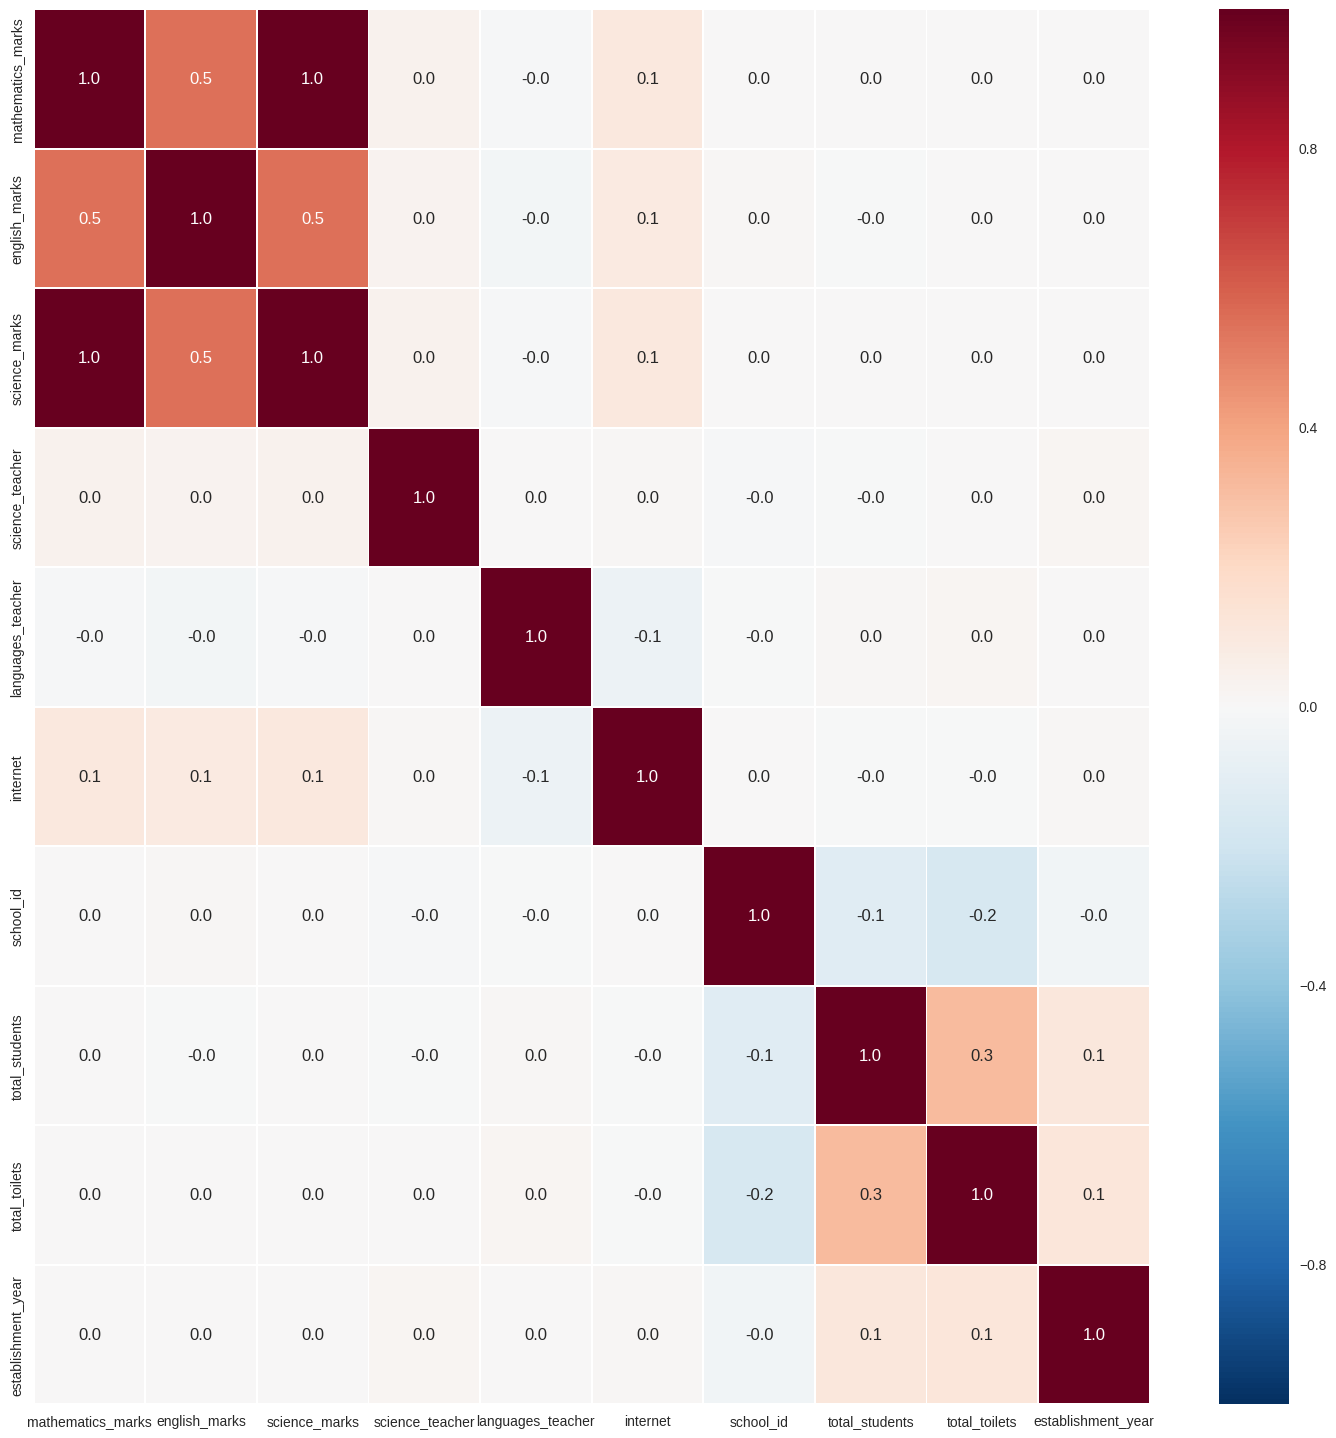

In [11]:
### Print correlation matrix
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(student.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

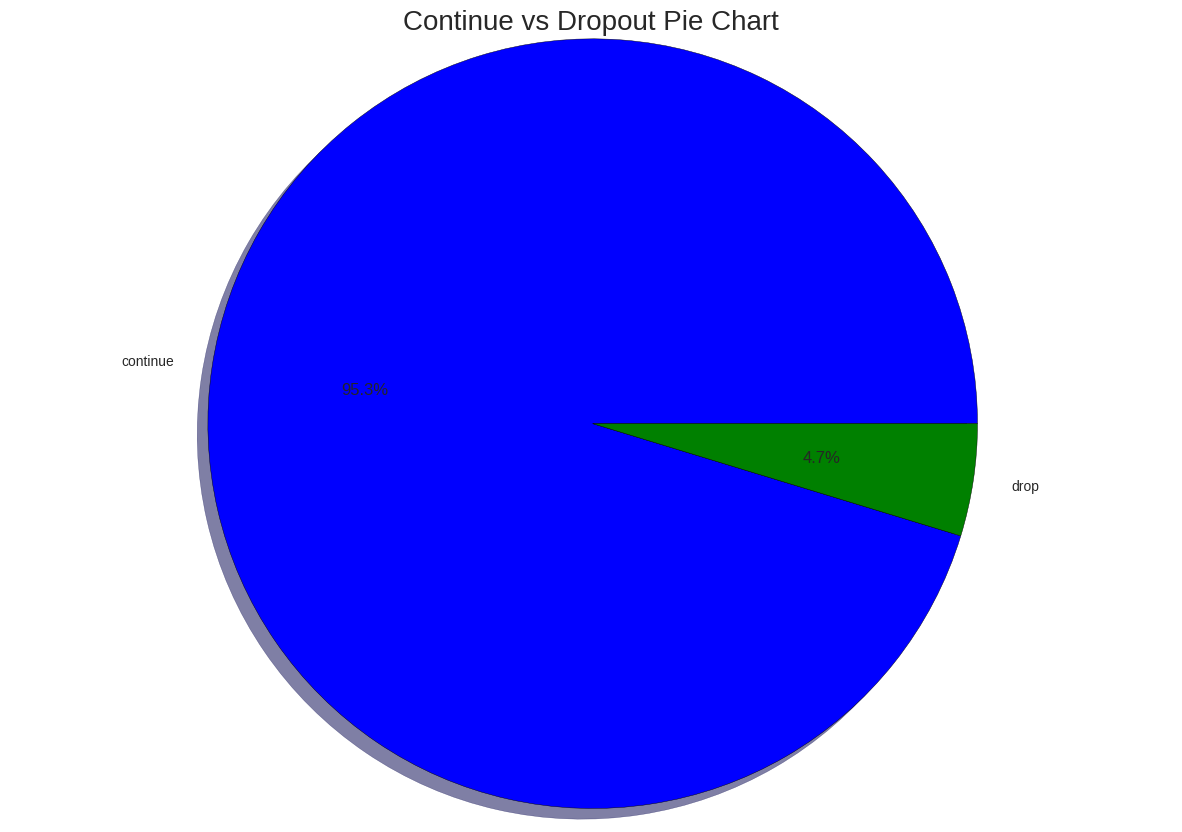

In [12]:
### Students' Marks in Math is absolutely correlated with Science
labels = ['continue', 'drop']
sizes = [student['continue_drop'].value_counts()[0],
         student['continue_drop'].value_counts()[1]
        ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Continue vs Dropout Pie Chart', fontsize=20)
plt.show()

In [14]:
predictors=list(range(0,15))
print(student.shape)

(19100, 15)


In [15]:
### H2O cannot use columns with character datatype. Creating Dummy variables instead
cols_to_transform = [ 'continue_drop','gender','caste','guardian','internet' ]
student = pd.get_dummies( student,columns = cols_to_transform )
student.head()

,student_id,mathematics_marks,english_marks,science_marks,science_teacher,languages_teacher,school_id,total_students,total_toilets,establishment_year,...,caste_BC,caste_OC,caste_SC,caste_ST,guardian_father,guardian_mixed,guardian_mother,guardian_other,internet_False,internet_True
0,s00001,0.409,0.514,0.409,6,0,310,262,28.0,1985.0,...,0,0,1,0,0,0,1,0,0,1
1,s00002,0.290,0.512,0.290,4,7,328,356,14.0,1943.0,...,1,0,0,0,0,0,1,0,0,1
2,s00003,0.602,0.666,0.602,4,2,322,179,8.0,1955.0,...,0,1,0,0,0,0,1,0,1,0
3,s00004,0.378,0.526,0.378,8,7,305,354,86.0,1986.0,...,1,0,0,0,0,0,1,0,0,1
4,s00005,0.536,0.614,0.536,9,4,360,273,2.0,1995.0,...,0,1,0,0,0,0,0,1,0,1


In [16]:
student.dtypes

student_id                 object
mathematics_marks         float64
english_marks             float64
science_marks             float64
science_teacher             int64
languages_teacher           int64
school_id                   int64
total_students              int64
total_toilets             float64
establishment_year        float64
continue_drop_continue      uint8
continue_drop_drop          uint8
gender_F                    uint8
gender_M                    uint8
caste_BC                    uint8
caste_OC                    uint8
caste_SC                    uint8
caste_ST                    uint8
guardian_father             uint8
guardian_mixed              uint8
guardian_mother             uint8
guardian_other              uint8
internet_False              uint8
internet_True               uint8
dtype: object

In [17]:
student = student.drop('student_id', 1)

In [18]:
student.dtypes

mathematics_marks         float64
english_marks             float64
science_marks             float64
science_teacher             int64
languages_teacher           int64
school_id                   int64
total_students              int64
total_toilets             float64
establishment_year        float64
continue_drop_continue      uint8
continue_drop_drop          uint8
gender_F                    uint8
gender_M                    uint8
caste_BC                    uint8
caste_OC                    uint8
caste_SC                    uint8
caste_ST                    uint8
guardian_father             uint8
guardian_mixed              uint8
guardian_mother             uint8
guardian_other              uint8
internet_False              uint8
internet_True               uint8
dtype: object

In [19]:
### Standardize input data
# Copy the original dataset
scaled_features = student.copy()

# Extract column names to be standardized
col_names = ['mathematics_marks','english_marks','science_marks',
             'science_teacher','languages_teacher','school_id',
             'total_students','total_toilets','establishment_year'#,
             #'gender_F','gender_M','caste_BC','caste_OC','caste_SC',
             #'caste_ST','guardian_father','guardian_mixed','guardian_mother',
            # 'guardian_other','internet_False','internet_True'
            ]

# Standardize the columns and re-assingn to original dataframe
features = scaled_features[col_names]
scaler = RobustScaler().fit_transform(features.values)
features = pd.DataFrame(scaler, index=student.index, columns=col_names)
scaled_features [col_names] = features
scaled_features.head()

,mathematics_marks,english_marks,science_marks,science_teacher,languages_teacher,school_id,total_students,total_toilets,establishment_year,continue_drop_continue,...,caste_BC,caste_OC,caste_SC,caste_ST,guardian_father,guardian_mixed,guardian_mother,guardian_other,internet_False,internet_True
0,-0.352159,-0.209677,-0.352159,0.50,-1.25,-0.790698,0.000000,0.928571,0.967213,1,...,0,0,1,0,0,0,1,0,0,1
1,-0.747508,-0.218894,-0.747508,0.00,0.50,-0.372093,0.454106,-0.071429,0.278689,1,...,1,0,0,0,0,0,1,0,0,1
2,0.289037,0.490783,0.289037,0.00,-0.75,-0.511628,-0.400966,-0.500000,0.475410,1,...,0,1,0,0,0,0,1,0,1,0
3,-0.455150,-0.154378,-0.455150,1.00,0.50,-0.906977,0.444444,5.071429,0.983607,1,...,1,0,0,0,0,0,1,0,0,1
4,0.069767,0.251152,0.069767,1.25,-0.25,0.372093,0.053140,-0.928571,1.131148,1,...,0,1,0,0,0,0,0,1,0,1


In [20]:
### Split dataset - dropped students as 'test' and continued students as 'train'
#student = student.astype(object)

train=scaled_features.loc[scaled_features['continue_drop_continue'] == 1]
test=scaled_features.loc[scaled_features['continue_drop_drop'] == 1]

## H2O Autoencoding and Anomaly detection

import h2o
h2o.init(ip="localhost", port=54323)

## Starting H2O cluster
h2o.init(nthreads=-1, enable_assertions = False)

train.hex=h2o.H2OFrame(train)
test.hex=h2o.H2OFrame(test)

https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/intro-to-r-python-flow/intro-to-python.py

^^^ H2o not working

### Andrew Ag
https://github.com/aqibsaeed/Anomaly-Detection

/home/octo/Dropbox/trading_system/atsL2P2/Anomaly-Detection/Anomaly Detection.ipynb

## Anomaly Detection Using One-Class SVM

In [2]:
import processing
import ds
import ml
import model_saving
import TS

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [110]:
filename = '/home/octo/Dropbox'+ '/SPY21Dec.csv'

In [111]:
import numpy as np
data=processing.get_csv_pd(filename)
data=processing.BA(data)
data=processing.preprocessing_feb(data)
data_km=ml.kalman_ma(data)
data['UD']=np.where(data.Close.diff(12)>0,1,-1)
data['C-km']=data.Close-data_km #np.where(data.Close>data_km,1,-1)

In [112]:
data=data.dropna()
data=data[5:29001]

In [113]:
data=data.drop(['askPrice','askSize','bidPrice','bidSize','vwap'],axis=1)

In [114]:
import pandas as pd
import talib

In [115]:
data['rsi']=talib.RSI(np.array(data.Close.astype('float64')))

In [116]:
data['atr']=talib.ATR(np.array(data.High.astype('float64')),np.array(data.Low.astype('float64')),np.array(data.Close.astype('float64')),timeperiod=20)

In [117]:
data['mom']=talib.MOM(np.array(data.Close.astype('float64')), timeperiod=5)

In [118]:
data=data.drop(['Open','High','Low','Volume',],axis=1)

In [119]:
data=data.dropna()

In [120]:
data.head()

,Close,trade,liq,spread,vel,return,UD,C-km,rsi,atr,mom
2017-12-21 20:00:11.833786,267.66501,90.00000,0.01001,-0.00488,-0.01999,0.00004,-1,0.24327,75.96017,0.01902,0.00500
2017-12-21 20:00:12.074544,267.66501,90.00000,0.00000,0.00000,-0.01498,0.00004,-1,0.21946,75.96017,0.01907,0.00000
2017-12-21 20:00:12.083926,267.67001,80.00000,0.00000,0.00000,-0.00998,0.00004,1,0.20298,83.24657,0.01912,0.00500
2017-12-21 20:00:12.092357,267.67001,80.00000,0.00998,-0.00394,-0.00497,0.00011,1,0.18309,83.24657,0.01966,0.00500
2017-12-21 20:00:12.100888,267.67499,-6.00000,0.00998,0.00186,0.00000,0.00011,1,0.17010,87.58432,0.01968,0.00998


In [62]:
from sklearn import svm

In [63]:
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [64]:
pred = clf.predict(data)

# inliers are labeled 1, outliers are labeled -1
normal =data[pred == 1]
abnormal =data[pred == -1]

In [68]:
data['N']=normal.Close
data['A']=abnormal.Close

In [69]:
data.head()

,Close,trade,liq,spread,vel,return,UD,C-km,rsi,atr,mom,N,A
2017-12-21 20:00:11.833786,267.66501,90.00000,0.01001,-0.00488,-0.01999,0.00004,-1,0.24327,75.96017,0.01902,0.00500,267.66501,nan
2017-12-21 20:00:12.074544,267.66501,90.00000,0.00000,0.00000,-0.01498,0.00004,-1,0.21946,75.96017,0.01907,0.00000,267.66501,nan
2017-12-21 20:00:12.083926,267.67001,80.00000,0.00000,0.00000,-0.00998,0.00004,1,0.20298,83.24657,0.01912,0.00500,267.67001,nan
2017-12-21 20:00:12.092357,267.67001,80.00000,0.00998,-0.00394,-0.00497,0.00011,1,0.18309,83.24657,0.01966,0.00500,267.67001,nan
2017-12-21 20:00:12.100888,267.67499,-6.00000,0.00998,0.00186,0.00000,0.00011,1,0.17010,87.58432,0.01968,0.00998,267.67499,nan


In [66]:
abnormal.head()

,Close,trade,liq,spread,vel,return,UD,C-km,rsi,atr,mom
2017-12-21 20:00:12.825996,267.67499,-120.00000,0.00998,0.00461,0.00000,0.00007,1,0.12592,87.58432,0.01972,0.00497
2017-12-21 20:00:17.332377,267.67499,-365.00000,0.00998,0.00455,0.00998,0.00004,-1,0.04189,87.58432,0.01614,0.00000
2017-12-21 20:00:18.084348,267.67499,-307.00000,0.00998,0.00452,0.00998,0.00004,-1,0.03430,87.58432,0.01554,0.00000
2017-12-21 20:00:18.875031,267.67499,-311.00000,0.00998,0.00455,0.01498,0.00004,-1,0.02808,87.58432,0.01499,0.00000
2017-12-21 20:00:19.614393,267.67499,-247.00000,0.00998,0.00439,0.01498,0.00004,-1,0.02299,87.58432,0.01450,0.00000


In [67]:
normal.head()

,Close,trade,liq,spread,vel,return,UD,C-km,rsi,atr,mom
2017-12-21 20:00:11.833786,267.66501,90.00000,0.01001,-0.00488,-0.01999,0.00004,-1,0.24327,75.96017,0.01902,0.00500
2017-12-21 20:00:12.074544,267.66501,90.00000,0.00000,0.00000,-0.01498,0.00004,-1,0.21946,75.96017,0.01907,0.00000
2017-12-21 20:00:12.083926,267.67001,80.00000,0.00000,0.00000,-0.00998,0.00004,1,0.20298,83.24657,0.01912,0.00500
2017-12-21 20:00:12.092357,267.67001,80.00000,0.00998,-0.00394,-0.00497,0.00011,1,0.18309,83.24657,0.01966,0.00500
2017-12-21 20:00:12.100888,267.67499,-6.00000,0.00998,0.00186,0.00000,0.00011,1,0.17010,87.58432,0.01968,0.00998


In [38]:
import matplotlib.pyplot as plt

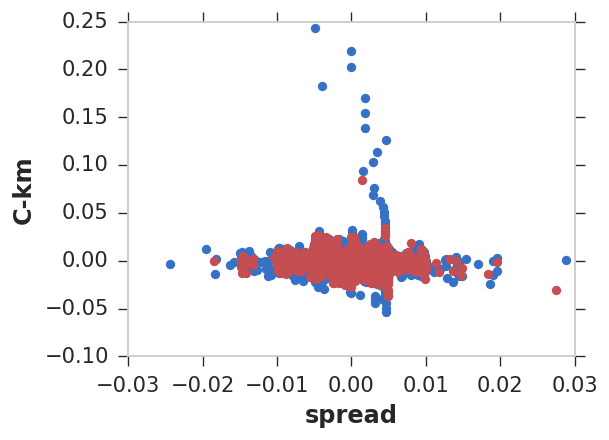

In [37]:
plt.figure()
plt.plot(normal.spread,normal['C-km'],'bo')
plt.plot(abnormal.spread,abnormal['C-km'],'ro')
plt.xlabel('spread')
plt.ylabel('C-km')
plt.show()

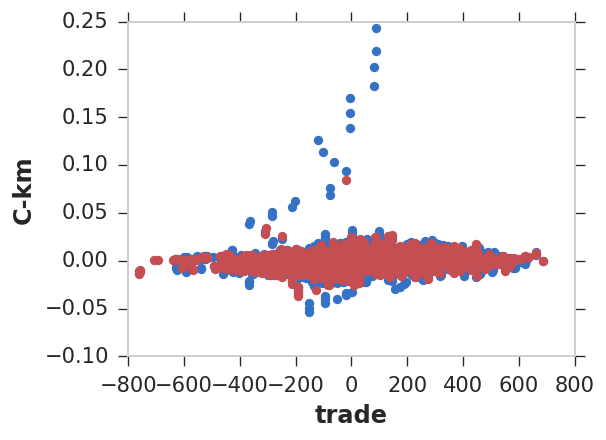

In [36]:
plt.figure()
plt.plot(normal.trade,normal['C-km'],'bo')
plt.plot(abnormal.trade,abnormal['C-km'],'ro')
plt.xlabel('trade')
plt.ylabel('C-km')
plt.show()

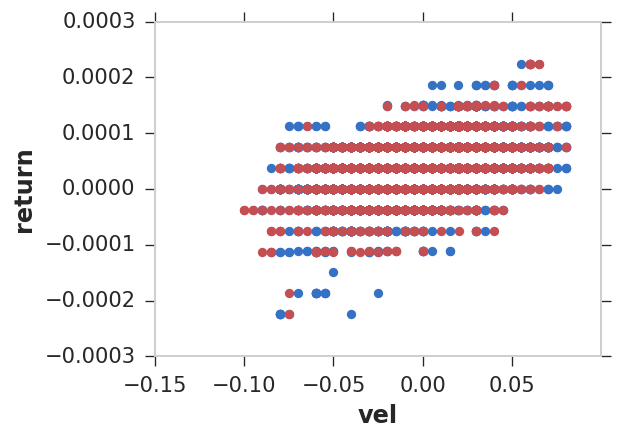

In [43]:
plt.figure()
plt.plot(normal.vel,normal['return'],'bo')
plt.plot(abnormal.vel,abnormal['return'],'ro')
plt.xlabel('vel')
plt.ylabel('return')
plt.show()

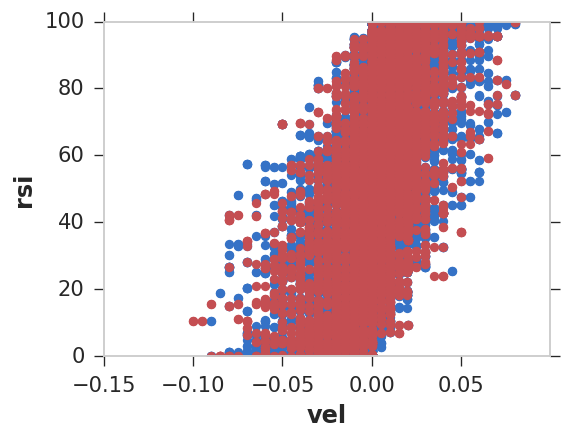

In [50]:
plt.figure()
plt.plot(normal.vel,normal.rsi,'bo')
plt.plot(abnormal.vel,abnormal.rsi,'ro')
plt.xlabel('vel')
plt.ylabel('rsi')
plt.show()

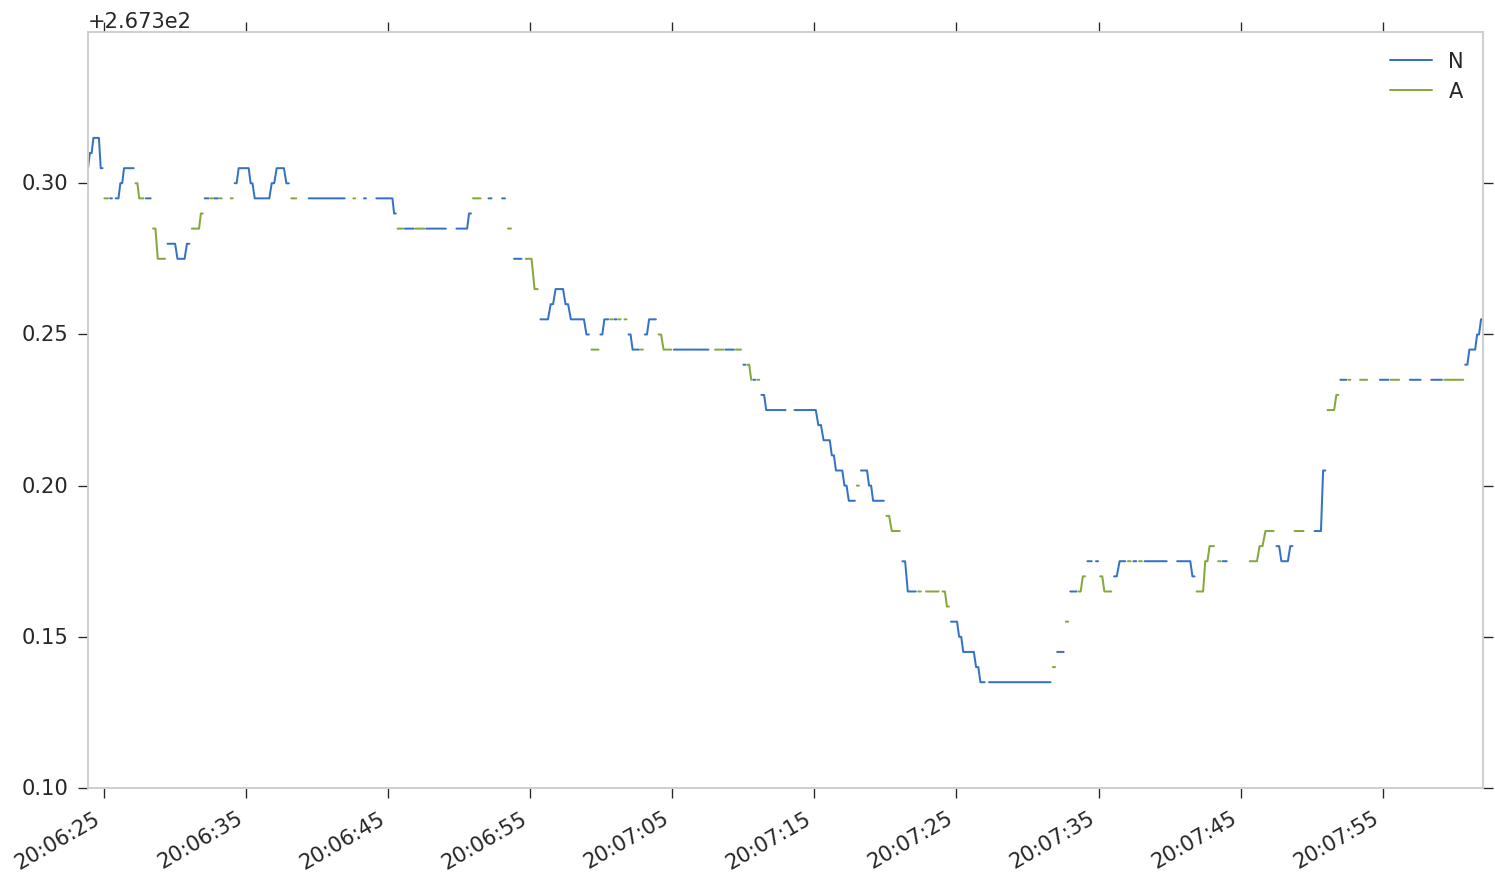

In [72]:
data[['N','A']][2000:2500].plot(figsize=(15,9))
plt.show()

In [76]:
data['Y']=pred

In [83]:
data[3000:3015]

,Close,trade,liq,spread,vel,return,UD,C-km,rsi,atr,mom,N,A,pred,Y
2017-12-21 20:09:39.277734,267.46500,-271.00000,0.01001,0.00485,0.01999,0.00000,-1,-0.00422,40.68342,0.02054,-0.01001,nan,267.46500,-1.00000,-1.00000
2017-12-21 20:09:39.461195,267.46500,-271.00000,0.01001,0.00485,0.01498,0.00000,-1,-0.00382,40.68342,0.02052,-0.01001,267.46500,nan,1.00000,1.00000
2017-12-21 20:09:39.642743,267.46500,-301.00000,0.01001,0.00488,0.01498,0.00000,-1,-0.00345,40.68342,0.02049,-0.00500,267.46500,nan,1.00000,1.00000
2017-12-21 20:09:39.827259,267.46500,-304.00000,0.01001,0.00497,0.00998,0.00000,-1,-0.00313,40.68342,0.02047,-0.00500,267.46500,nan,1.00000,1.00000
2017-12-21 20:09:40.047471,267.46500,-304.00000,0.00000,0.00000,0.00998,0.00000,-1,-0.00330,40.68342,0.02044,0.00000,267.46500,nan,1.00000,1.00000
2017-12-21 20:09:40.285216,267.47000,-3.00000,0.00000,0.00000,0.01498,0.00000,-1,0.00154,56.09435,0.02042,0.00500,267.47000,nan,1.00000,1.00000
2017-12-21 20:09:40.523182,267.47000,-3.00000,0.01001,0.00302,0.01498,0.00004,-1,0.00092,56.09435,0.02040,0.00500,267.47000,nan,1.00000,1.00000
2017-12-21 20:09:40.759223,267.47501,199.00000,0.01001,-0.00479,0.01999,0.00004,-1,0.00536,66.26057,0.02038,0.01001,nan,267.47501,-1.00000,-1.00000
2017-12-21 20:09:41.001546,267.47501,199.00000,0.01001,-0.00479,0.01999,0.00007,-1,0.00485,66.26057,0.02037,0.01001,nan,267.47501,-1.00000,-1.00000
2017-12-21 20:09:41.238248,267.47501,199.00000,0.01001,-0.00479,0.03000,0.00007,1,0.00439,66.26057,0.02035,0.01001,nan,267.47501,-1.00000,-1.00000


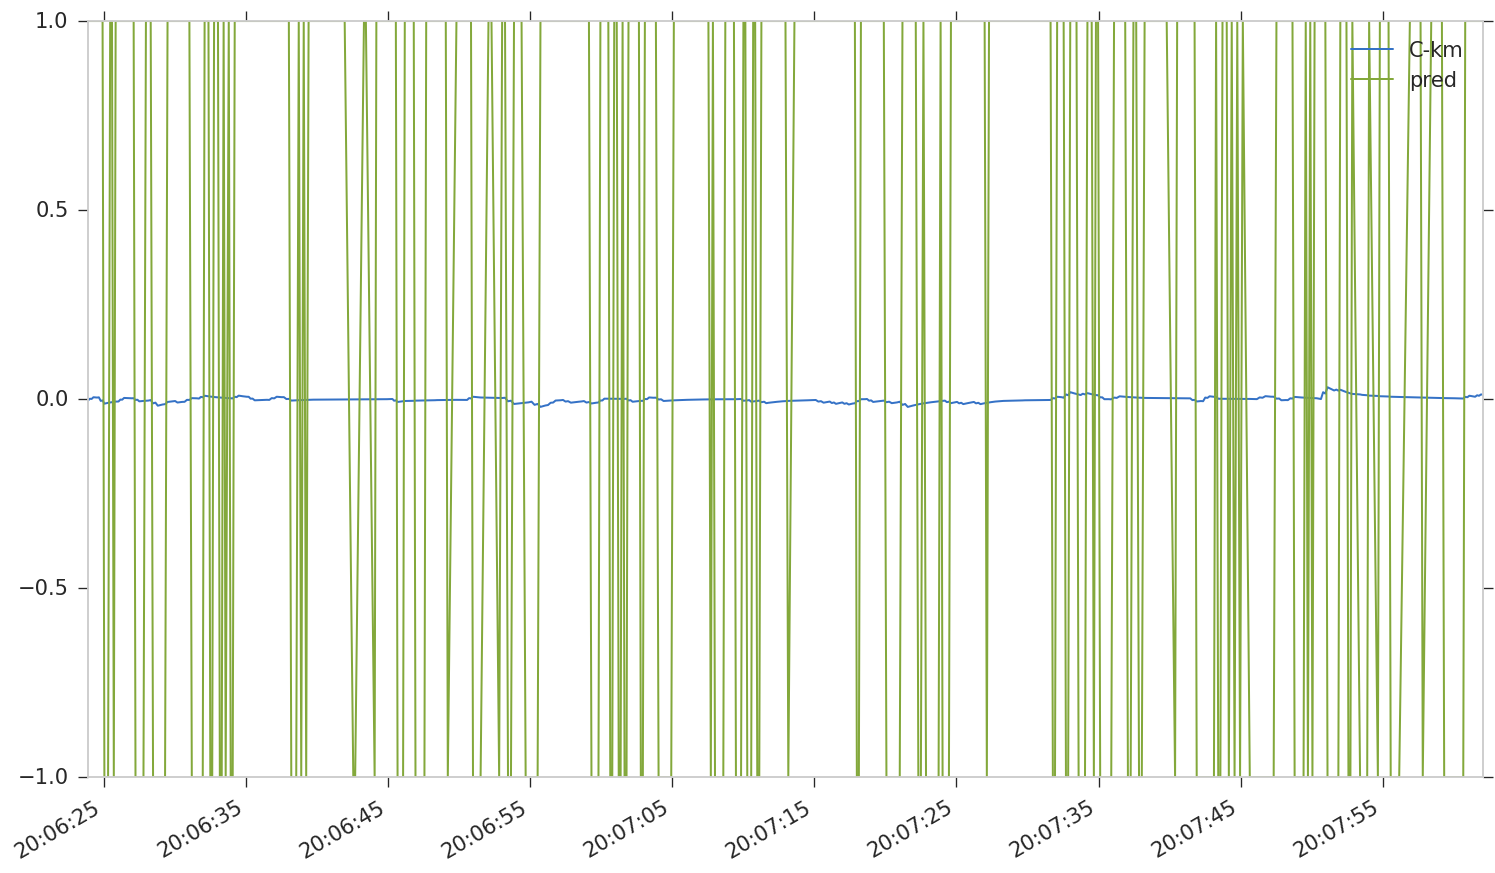

In [82]:
data[['C-km','pred']][2000:2500].plot(figsize=(15,9))
plt.show()

https://plot.ly/scikit-learn/plot-outlier-detection/

based on a robust estimator of covariance, which is assuming that the data are Gaussian distributed and performs better than the One-Class SVM in that case.

using the One-Class SVM and its ability to capture the shape of the data set, hence performing better when the data is strongly non-Gaussian, i.e. with two well-separated clusters;

using the Isolation Forest algorithm, which is based on random forests and hence more adapted to large-dimensional settings, even if it performs quite well in the examples below.

In [121]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [122]:
rng = np.random.RandomState(42)
outliers_fraction=0.05
n_samples=200
ifrst=IsolationForest(max_samples=n_samples,contamination=outliers_fraction,random_state=rng)
ifrst.fit(data)

IsolationForest(bootstrap=False, contamination=0.05, max_features=1.0,
        max_samples=200, n_estimators=100, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x7fd4e5712480>,
        verbose=0)

In [123]:
pred=ifrst.predict(data)

In [124]:
# inliers are labeled 1, outliers are labeled -1
normal =data[pred == 1]
abnormal =data[pred == -1]
data['N']=normal.Close
data['A']=abnormal.Close

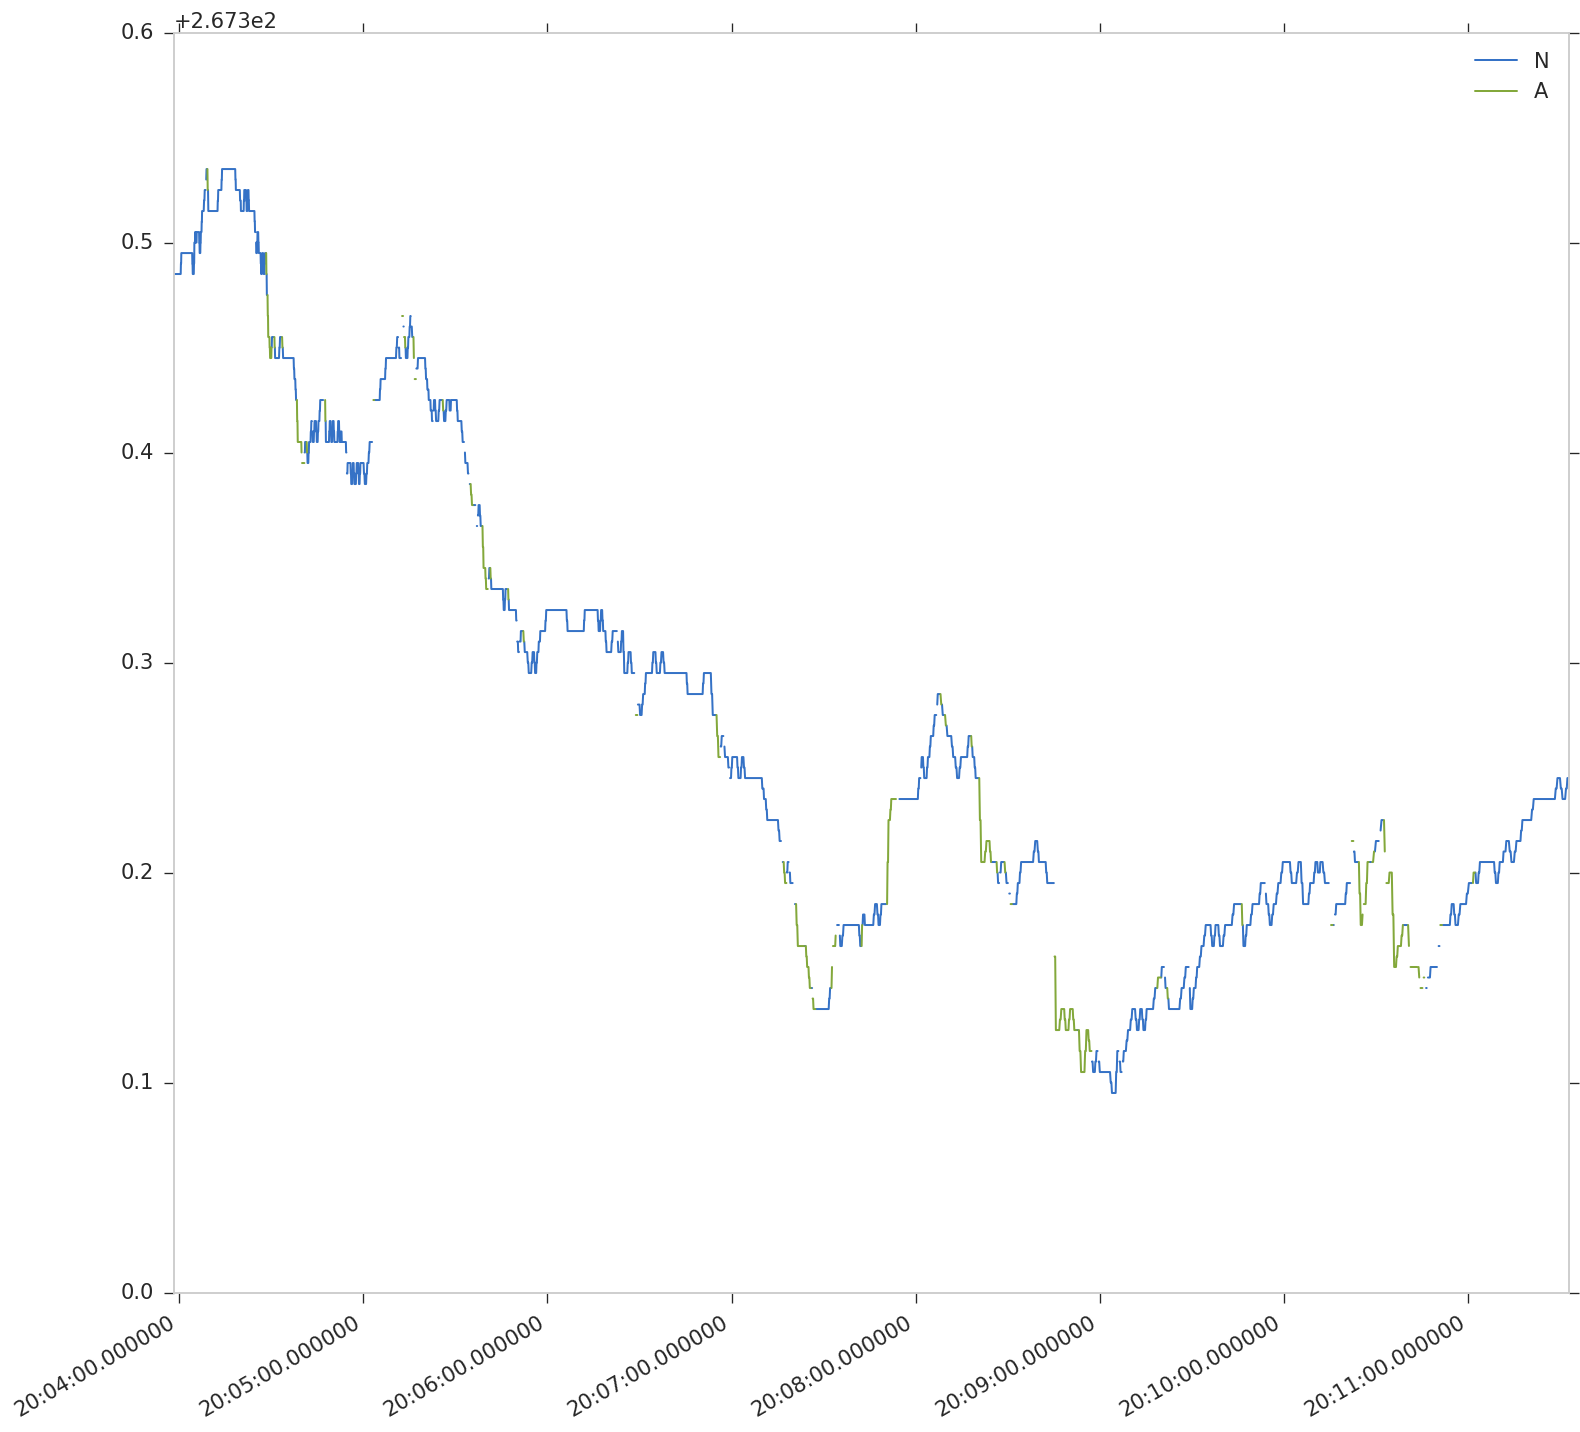

In [127]:
data[['N','A']][1000:3500].plot(figsize=(15,15))
plt.show()

http://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection

    http://blog.yhat.com/posts/detecting-outlier-car-prices-on-the-web.html
    https://github.com/vc1492a/PyNomaly
    https://github.com/Y-oHr-N/kenchi
    https://github.com/anrputina/OutlierDenStream
    https://github.com/IceKhan13/anomaly-detection-libs
    https://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
    http://dsdeepdive.blogspot.com/2016/01/anomaly-detection-with-python.html
    https://github.com/enesozi/Credit-Risk-Analysis/blob/master/Credit%20Risk%20Analysis.ipynb


### XGBOD (Extreme Boosting Based Outlier Detection)

    https://github.com/yzhao062/XGBOD

### Change Detection

https://stats.stackexchange.com/questions/59895/python-module-for-change-point-analysis

https://github.com/amanahuja/change-detection-tutorial

https://github.com/hildensia/bayesian_changepoint_detection/blob/master/Example%20Code.ipynb

https://pafnuty.wordpress.com/2014/05/29/change-detection-tutorial/

https://github.com/BorgwardtLab/PyChange